In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

TIM = p.TIM
GAL = p.AstroDeep
LMK = p.LADUMA # LADUMA with Meerkat
# TIME = p.TIME
FYST = p.FYST
#GAL = p.Euclid
CII = l.CII
HI = l.HI
CO43 = l.CO43

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

# dlnk = 2
dlnk = 0.6

# TODO(shubh): figure out what this value is and how it comes in, and units

#colors = ['black', 'purple', 'blue', 'gold', 'red', 'black']
colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [4]:
# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'LW', 'LW'] 

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


In [5]:
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

703036143029.9122 Mpc3 Jy2
1331424515709.3003 Mpc3 Jy2
635017875208.5846 Mpc3 Jy2
972729789399.4702 Mpc3 Jy2


In [6]:
#Sanity check on the kscale of the bin LoS
for lsb in LSbins:
    print(np.around(lsb.LoS, 2), 'or k = ', np.around(2*np.pi / lsb.LoS, 4))

508.99 Mpc or k =  0.0123 1 / Mpc
439.17 Mpc or k =  0.0143 1 / Mpc
497.76 Mpc or k =  0.0126 1 / Mpc
416.27 Mpc or k =  0.0151 1 / Mpc


In [7]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

print(len(k_xyz_modes))
[print(kxyzs.shape) for kxyzs in k_xyz_modes]

4
(3, 20, 102, 39)
(3, 20, 102, 29)
(3, 15, 77, 39)
(3, 15, 77, 30)


[None, None, None, None]

In [8]:
# above different from Juzz because he uses wrong "azScan" field size
# a lot is going to be different now, because this is a major change
# refer to CII_Xcorr_shubh.ipynb instead now.

In [9]:
# these arrays are similarly structured:
# arr[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

num_kbins

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_45766/478757844.py:13: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[16, 15, 15, 14]

In [10]:
k_props[0].shape

(3, 20, 102, 39)

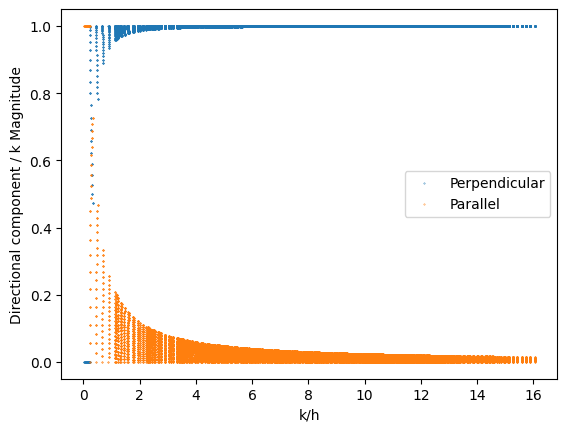

In [11]:
# making a plot for bin1
plt.figure()
plt.plot(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='.', linestyle='None', markersize=.6, label = 'Perpendicular')
#plt.plot(k1Mag.flatten(), ky1Props.flatten(), marker='.', linestyle='None')
plt.plot(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', markersize=.6, label = 'Parallel')
plt.xlabel('k/h')
plt.ylabel('Directional component / k Magnitude')
plt.legend()

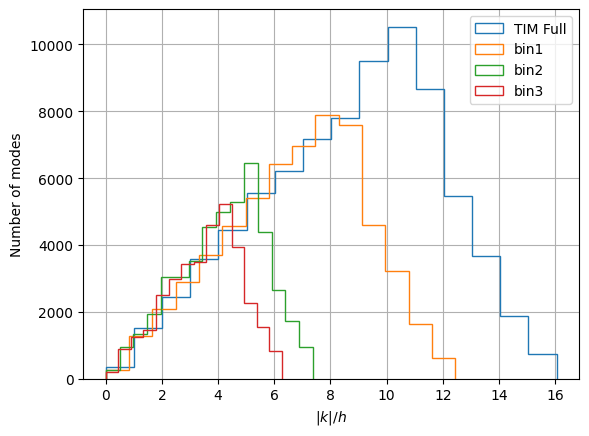

In [12]:
plt.figure()
for i in range(len(k_mags)):
    if i == 0 or i == 5:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = 'TIM Full', histtype='step')
    else:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = f'bin{i}', histtype='step')

plt.xlabel(r'$|k|/h$')
plt.ylabel('Number of modes')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [13]:
# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value for b, band in zip(bins, bands)]

In [14]:
s_perps

[0.11755244692217426,
 0.1516503189988713,
 0.24571221408768276,
 0.28908943552124405]

In [15]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

In [15]:
windows[0].shape

(20, 102, 39)

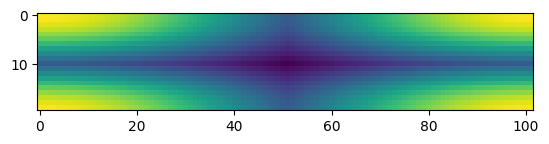

In [16]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

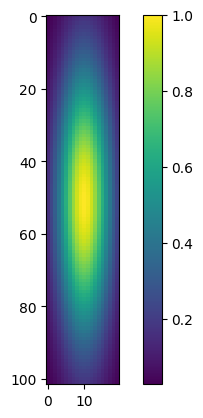

In [17]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

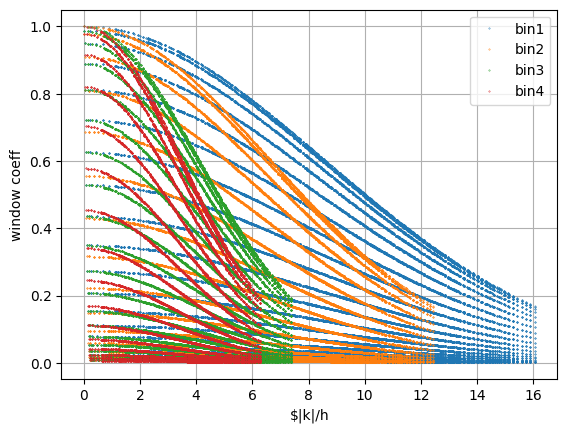

In [18]:
plt.figure()
for i in range(len(k_mags)):
    plt.plot(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = 'bin'+str(i+1), markersize=.6)

plt.xlabel(r'$|k|/h')
plt.ylabel('window coeff')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [19]:
# window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
#                 for i in range(len(kb)-1)]) 
#         for win, km, kb in zip(windows, k_mags, k_bins)]

In [20]:
bin_zs

[0.6435273234436414,
 0.8875998478508937,
 1.1728794218333967,
 1.4993660453911497]

In [21]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=True) 
# TODO: why not nonlinear?
# TODO: why not much higher kmax?

results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [22]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[0, 1, 2, 2]


In [23]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

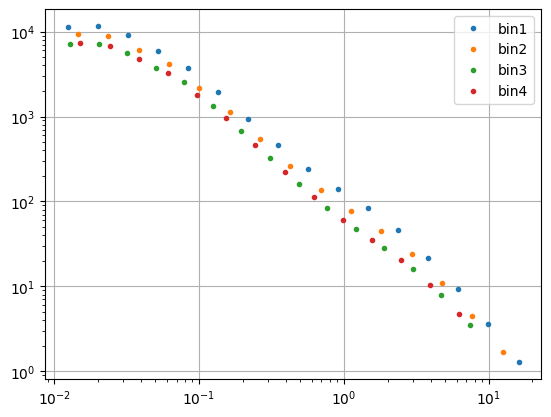

In [24]:
plt.figure()
for i in range(len(Pms)):
    plt.plot(Pms[i][0], Pms[i][1], label = 'bin'+str(i+1), linestyle='none', marker='.')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [25]:
3.38994999e-03 / 5.44490142e-03, 9.34911274e-02 / 1.50164449e-01 # log scale from CAMB

(0.622591618931459, 0.6225916188724536)

In [26]:
# TODO: something fishy here, the windowing bins are linspaced, 
# but the camb bins are logspaced, that is inconsistent!

In [27]:
Pms[0][0]

array([1.23885979e-02, 1.99766269e-02, 3.22123315e-02, 5.19424178e-02,
       8.37572022e-02, 1.35058575e-01, 2.17782091e-01, 3.51173847e-01,
       5.66268190e-01, 9.13108039e-01, 1.47238765e+00, 2.37422661e+00,
       3.82844286e+00, 6.17336805e+00, 9.95456235e+00, 1.60517420e+01])

In [28]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

c:\Users\shubh\.conda\envs\lim\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shubh\.conda\envs\lim\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


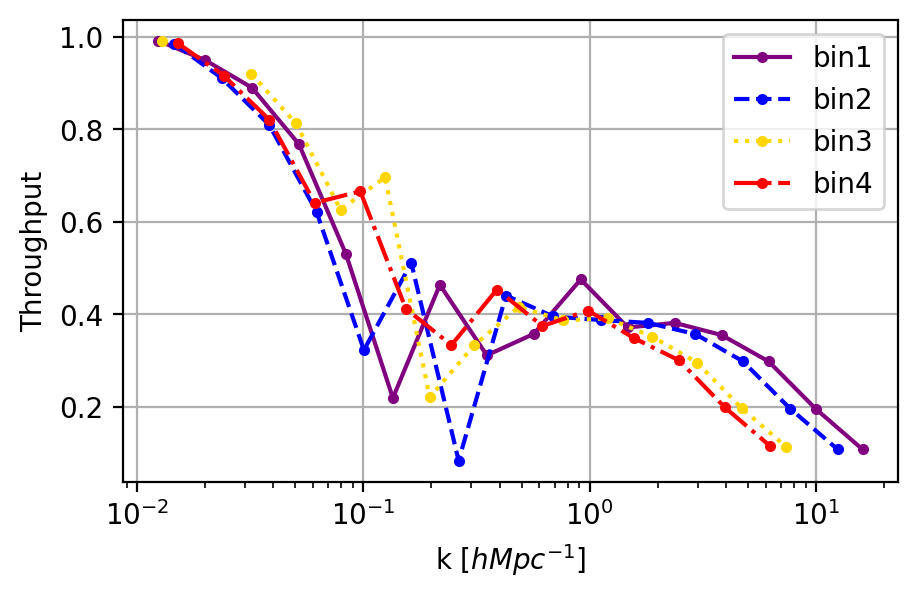

In [29]:
plt.figure(dpi = 200, figsize = (5,3))
for i in range(len(Pms)):
    plt.plot(Pms[i][0], window_avgs[i], label = 'bin'+str(i+1), marker='.', 
             color = colors[i], linestyle = linestyles[i])

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Throughput')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()
plt.close()

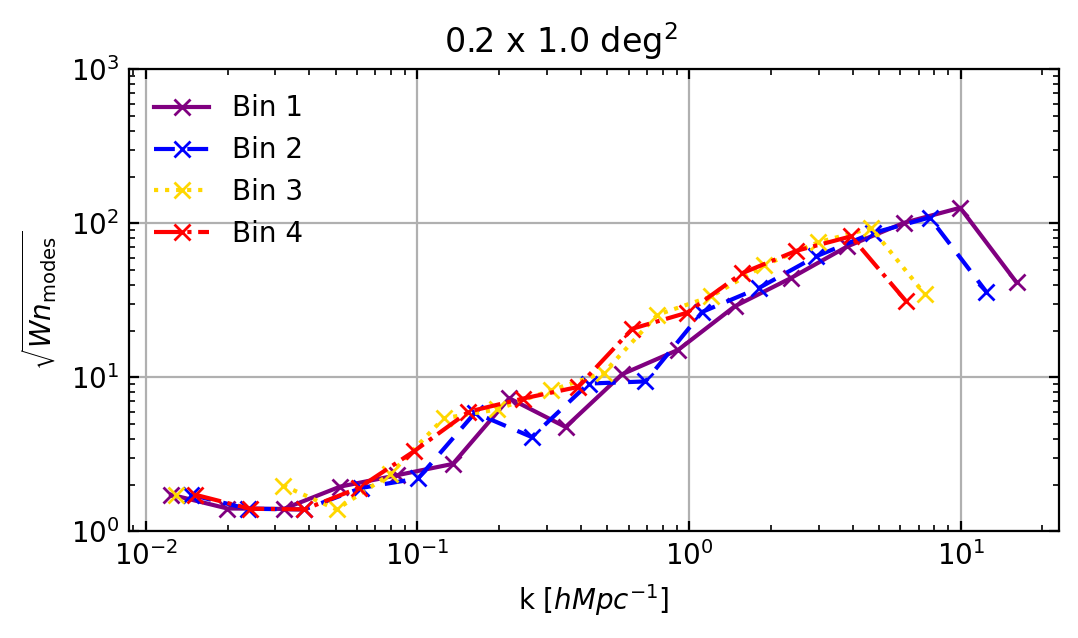

In [116]:
# compute the number of modes in each bin, using the RIGHT bin edges
num_modes = [np.array([np.sum(np.logical_and(km < kb[i+1], km >= kb[i]))
                for i in range(len(kb)-1)])
        for km, kb in zip(k_mags, kbin_edges)]

plt.figure(dpi = 200, figsize = (6,3))
for i,((ks,_),nums, col) in enumerate(zip(Pms,num_modes, colors)):
    plt.loglog(ks, np.sqrt(window_avgs[i] * nums), color = col, linestyle = linestyles[i], marker = 'x', label = 'Bin ' + str(i+1))

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel(r'$\sqrt{W n_\text{modes}}$')
plt.ylim(1, 1e3)
plt.title(f"{TIM.Daz.value} x {TIM.Del.value}" r" deg$^2$" "\t") # f"{np.sqrt(np.nanmean(window_avgs[i] * nums)):.2e}")

plt.grid()
plt.legend()

In [117]:
Iciis = np.array([CII.Inu(z).value for z in bin_zs])
Iciis

array([2369.81019798, 2838.39908081, 3196.2379617 , 3258.75366254])

In [118]:
reload(l); HI = l.HI

In [119]:
T_HIs = np.array([HI.T(z).to("mK").value for z in bin_zs])
I_HIs = np.array([HI.Inu(z).to("Jy/sr").value for z in bin_zs])
T_HIs, I_HIs

(array([0.11509341, 0.13994209, 0.1741259 , 0.22284878]),
 array([2.66791062, 2.45925278, 2.309228  , 2.23370195]))

In [120]:
T_HIs[0] ** 2 * Pms[0][1], I_HIs[0] ** 2 * Pms[0][1]

(array([1.51606086e+02, 1.54926151e+02, 1.20279370e+02, 7.80467033e+01,
        4.94843248e+01, 2.60292275e+01, 1.24620529e+01, 6.16696923e+00,
        3.23378488e+00, 1.84911766e+00, 1.09836759e+00, 6.06143640e-01,
        2.89313471e-01, 1.22110773e-01, 4.72492040e-02, 1.70673633e-02]),
 array([8.14626059e+04, 8.32465790e+04, 6.46297994e+04, 4.19368906e+04,
        2.65894475e+04, 1.39863033e+04, 6.69624376e+03, 3.31370196e+03,
        1.73761193e+03, 9.93587708e+02, 5.90186639e+02, 3.25699593e+02,
        1.55457013e+02, 6.56138687e+01, 2.53884484e+01, 9.17081844e+00]))

skipping below cells from TIMxGal case

fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
#TODO- Juzz - Recall where we got this number.
Igal, bCII, bstar = 1, 1, 3

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]

x_noise = [np.sqrt(lsb.cell_noise(TIM.time).value / (2 * n_gal * nm * w))
        for lsb, n_gal, nm, w in zip(LSbins, GAL.n_gals, num_modes, window_avgs)]
SNR_PxG = [PxG / xn for PxG, xn in zip(PxGs, x_noise)]

In [121]:
# compute power spectrum of CII and HI
bCII = 1
PCIIs = [bCII ** 2 * Icii ** 2 * Pm[1] for Icii, Pm in zip(Iciis, Pms)]
PHIs = [T_HI ** 2 * Pm[1] for T_HI, Pm in zip(T_HIs, Pms)]

# P_cross, ignoring the shot term for now TODO(shubh)
Pcross = [bCII * Icii * T_HI * Pm[1] for Icii, T_HI, Pm in zip(Iciis, T_HIs, Pms)]

# fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
# for i in range(len(Pms)):
#     # norm = Pms[i][0] ** 3 / (2 * np.pi ** 2)
#     norm = 1
#     axs[i//2, i%2].plot(Pms[i][0], norm * PCIIs[i], label = 'CII', color = 'blue')
#     axs[i//2, i%2].plot(Pms[i][0], norm * PHIs[i], label = 'HI', color = 'red')
#     axs[i//2, i%2].plot(Pms[i][0], norm * Pcross[i], label = 'CII-HI', color = 'green')
#     axs[i//2, i%2].set_xscale('log')
#     axs[i//2, i%2].set_yscale('log')
#     axs[i//2, i%2].set_title(f"Bin {i+1}")
#     axs[i//2, i%2].grid()
#     axs[i//2, i%2].legend()

# plt.show()
# plt.close()

In [122]:
# TODO(shubh): no windowing yet

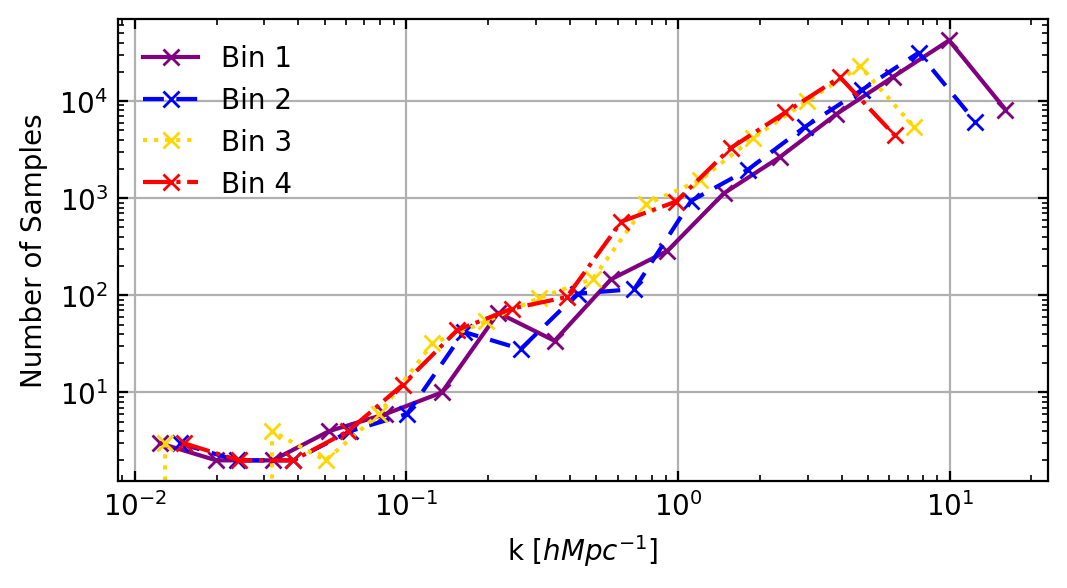

In [123]:
# compute the number of modes in each bin, using the RIGHT bin edges
num_modes = [np.array([np.sum(np.logical_and(km < kb[i+1], km >= kb[i]))
                for i in range(len(kb)-1)])
        for km, kb in zip(k_mags, kbin_edges)]

plt.figure(dpi = 200, figsize = (6,3))
for i,((ks,_),nums, col) in enumerate(zip(Pms,num_modes, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x', label = 'Bin ' + str(i+1))

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Number of Samples')

plt.grid()
plt.legend()

In [128]:
cross_var = [None] * len(bin_zs)
pcii_var = [None] * len(bin_zs)
phi_var = [None] * len(bin_zs)

for i, z in enumerate(bin_zs):
    nei = TIM.SW.NEI if i < 2 else TIM.LW.NEI
    nei = nei.value * u.Jy / u.sr
    num_pix = TIM.SW.num_dets if i < 2 else TIM.LW.num_dets
    fwhm = TIM.SW.FWHM if i < 2 else TIM.LW.FWHM
    dnu = TIM.SW.dnu if i < 2 else TIM.LW.dnu
    tpix = TIM.time * num_pix * 2 * np.pi * fwhm * fwhm / (8 * np.log(2)) / TIM.Daz / TIM.Del
    Vpix = 1.1e3 / cosmo.h ** 3 * u.Mpc ** 3 * ((1+z) / 8) ** 0.5 * (fwhm / 10 * u.arcmin) ** 2 * \
        (dnu / 400 * u.MHz)
    PNCII = (Vpix * nei * nei / tpix).to("Jy2 Mpc3 / s3").value
    # print(PNCII.to("Jy2 Mpc3 / s3").value, PCIIs[i])
    # print(PCIIs[i] / PNCII.to("Jy2 Mpc3 / s3").value)
    
    r_nu = c.c * (1+z) ** 2 / cosmo.H(z)
    l21 = (21*u.cm * (1+z))
    nu21_0 = 1420 * u.MHz
    xi2 = cosmo.comoving_distance(z) ** 2
    Aeff = np.pi * LMK.dish ** 2 / 4
    n_u_z = LMK.ndish ** 2 / (2 * np.pi * (l21 / LMK.maxbase) ** 2)
        
    PNHI = LMK.Tsys ** 2 * xi2 * r_nu * l21 ** 4 / (Aeff ** 2 * LMK.time * 2 * nu21_0 * n_u_z)

    PNHI = PNHI.to("mK2 Mpc3").value
    
    # ks = Pms[i][0]
    # Vsur = 3.7e7 / cosmo.h ** 3 * u.Mpc ** 3 * ((1+z) / 8) ** 0.5 * (TIM.Daz * TIM.Del / (16 * u.deg ** 2)) * \
    #     (c.c/ut.z2l_CII(bins[i].front) - c.c/ut.z2l_CII(bins[i].back)) / (20 * u.GHz)
    # nmodes = (2 * np.pi) ** -2 * ks ** 2 * Vsur * (ks - np.append([0], ks[:-1]))
    # nmodes = nmodes.to("Mpc3").value
    nmodes = num_modes[i]
    
    # print(nmodes, num_modes[i])
    
    pcii_var[i] = (PCIIs[i] + PNCII) ** 2 / (nmodes)
    phi_var[i] = (PHIs[i] + PNHI) ** 2 / (nmodes)
    cross_var[i] = ((PCIIs[i] + PNCII) * (PHIs[i] + PNHI) + Pcross[i] ** 2) / (2 * nmodes)
    
    print(f"bin {i+1}:")
    print("CII:", np.sqrt(np.sum(PCIIs[i] ** 2 / pcii_var[i])))
    print(PCIIs[i] / np.sqrt(pcii_var[i]))
    print("HI:", np.sqrt(np.sum(PHIs[i] ** 2 / phi_var[i])))
    print(PHIs[i] / np.sqrt(phi_var[i]))
    print("Cross:", np.sqrt(np.sum(Pcross[i] ** 2 / cross_var[i])))
    print(Pcross[i] / np.sqrt(cross_var[i]))

bin 1:
CII: 0.6129742387453245
[0.33380318 0.27734725 0.2251997  0.2188941  0.17707036 0.12451037
 0.15635487 0.05607947 0.06121691 0.04909922 0.05773084 0.04910636
 0.03899167 0.02552476 0.01526559 0.00242841]
HI: 282.06027724538933
[  1.73205081   1.41421356   1.41421356   2.           2.44948974
   3.16227766   8.1240384    5.83095189  12.08304597  16.91153453
  33.43650699  51.49757276  85.62709851 132.77047865 205.19259246
  90.36038955]
Cross: 6.313455663061024
[0.98462543 0.80983795 0.74125848 0.88836969 0.89943522 0.87042611
 1.57876391 0.80483757 1.21322557 1.28680953 1.96315586 2.24786527
 2.58349522 2.60318414 2.50285959 0.66245977]
bin 2:
CII: 0.6137692574323159
[0.35977219 0.27901144 0.20735731 0.20702071 0.14076864 0.1963858
 0.07994048 0.0745683  0.040942   0.06603866 0.05555836 0.04897847
 0.0348586  0.02211642 0.00365006]
HI: 243.22828782762102
[  1.73205081   1.41421356   1.41421356   2.           2.44948974
   6.4807407    5.29150262  10.19803903  10.77032961  30.659

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_62939/3737962383.py:38: RuntimeWarning: divide by zero encountered in divide
  pcii_var[i] = (PCIIs[i] + PNCII) ** 2 / (nmodes)
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_62939/3737962383.py:39: RuntimeWarning: divide by zero encountered in divide
  phi_var[i] = (PHIs[i] + PNHI) ** 2 / (nmodes)
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_62939/3737962383.py:40: RuntimeWarning: divide by zero encountered in divide
  cross_var[i] = ((PCIIs[i] + PNCII) * (PHIs[i] + PNHI) + Pcross[i] ** 2) / (2 * nmodes)


x_noise = [np.sqrt(lsb.cell_noise(TIM.time).value / (2 * n_gal * nm * w))
        for lsb, n_gal, nm, w, PxG in zip(LSbins, GAL.n_gals, num_modes, window_avgs, PxGs)]
SNR_PxG = [PxG / xn for PxG, xn in zip(PxGs, x_noise)]

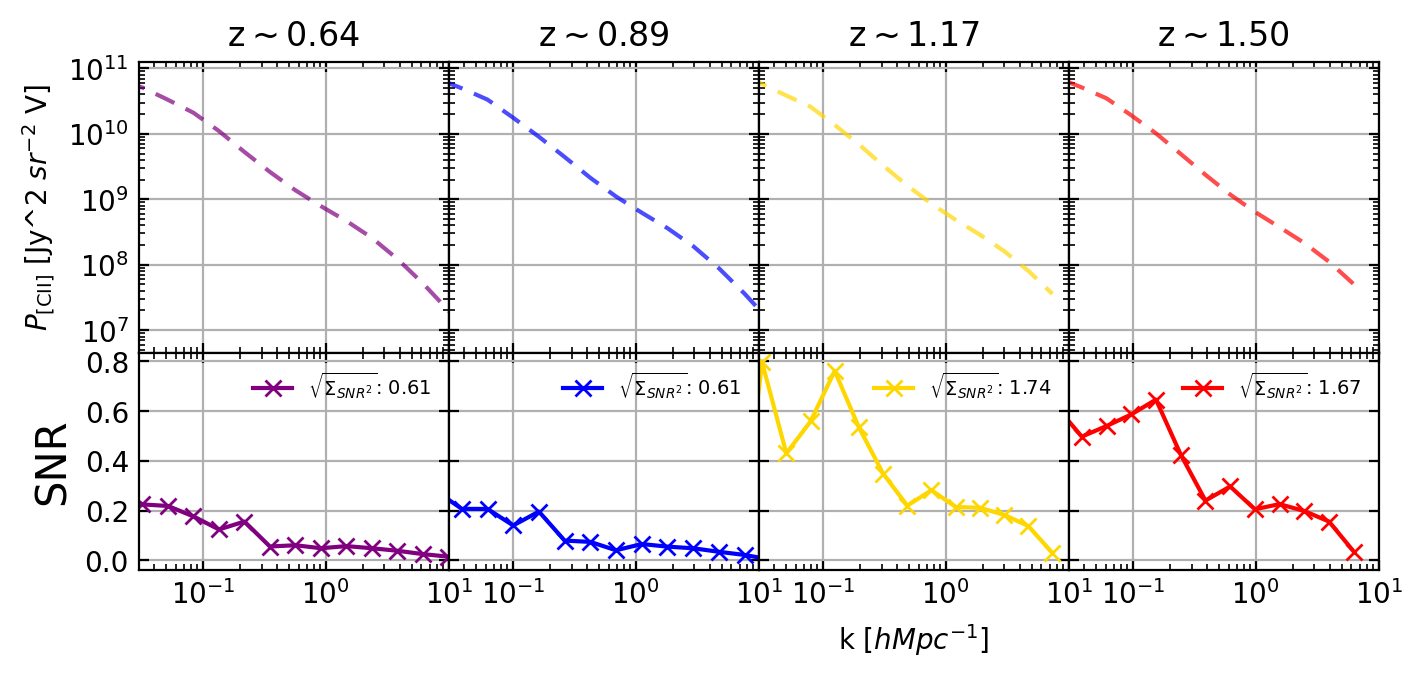

In [133]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PCIIs):
    power[i].loglog(Pms[i][0], PCIIs[i], color = colors[i], linestyle = '--', alpha = .7)
    # power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    # power[i].fill_between(Pms[i][0], PCIIs[i] + np.sqrt(pcii_var[i]),
    #                PCIIs[i] - np.sqrt(pcii_var[i]), color = colors[i], alpha = .4)
    power[i].set_title(r"z$\sim$"+f"{bins[i].center:.2f}")
    
    SNR_Pcii = PCIIs[i] / np.sqrt(pcii_var[i])
    
    quad_snr = np.sqrt(np.sum(SNR_Pcii ** 2))
    
    SNR[i].plot(Pms[i][0], SNR_Pcii, color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_snr,2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    SNR[i].set_yticks(np.arange(0, 1, .20))


power[0].set_ylabel(r"$P_\text{[CII]}$ [Jy^2 $sr^{-2}$ V]", size = 10)

SNR[0].set_ylabel(r"SNR", size = 15)
power[0].set_xlim(3e-2, 1e1)

# power[0].set_ylim(1e3, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

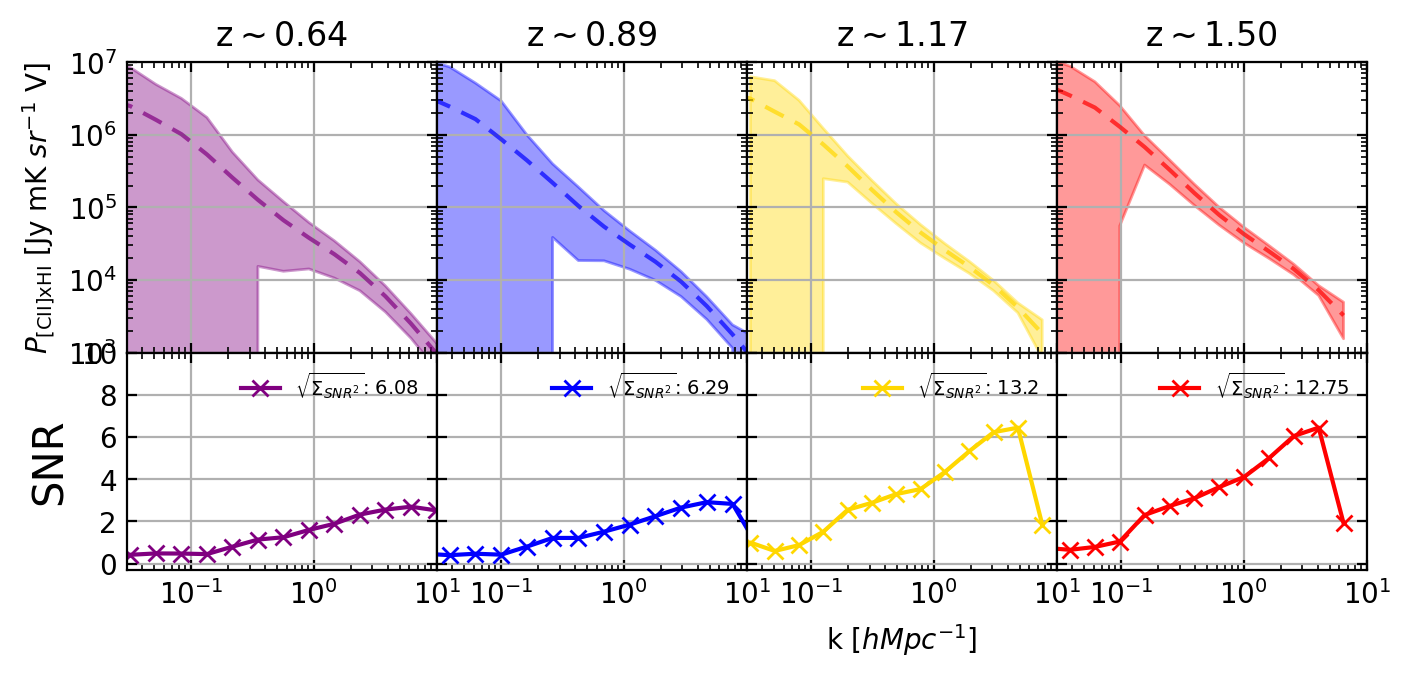

In [739]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(Pcross):
    power[i].loglog(Pms[i][0], Pcross[i], color = colors[i], linestyle = '--', alpha = .7)
    # power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], Pcross[i] + np.sqrt(cross_var[i]),
                   Pcross[i] - np.sqrt(cross_var[i]), color = colors[i], alpha = .4)
    power[i].set_title(r"z$\sim$"+f"{bins[i].center:.2f}")
    
    SNR_Pcross = Pcross[i] / np.sqrt(cross_var[i])
    
    quad_snr = np.sqrt(np.sum(SNR_Pcross ** 2))
    
    SNR[i].plot(Pms[i][0], SNR_Pcross, color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_snr,2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    SNR[i].set_yticks(np.arange(0, 11, 2.0))


power[0].set_ylabel(r"$P_\text{[CII]xHI}$ [Jy mK $sr^{-1}$ V]", size = 10)

SNR[0].set_ylabel(r"SNR", size = 15)
power[0].set_xlim(3e-2, 1e1)

power[0].set_ylim(1e3, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

In [31]:
bI_CO43s = np.array([CO43.bI.to("Jy/sr").value for z in bin_zs])
bI_CO43s

array([300., 300., 300., 300.])

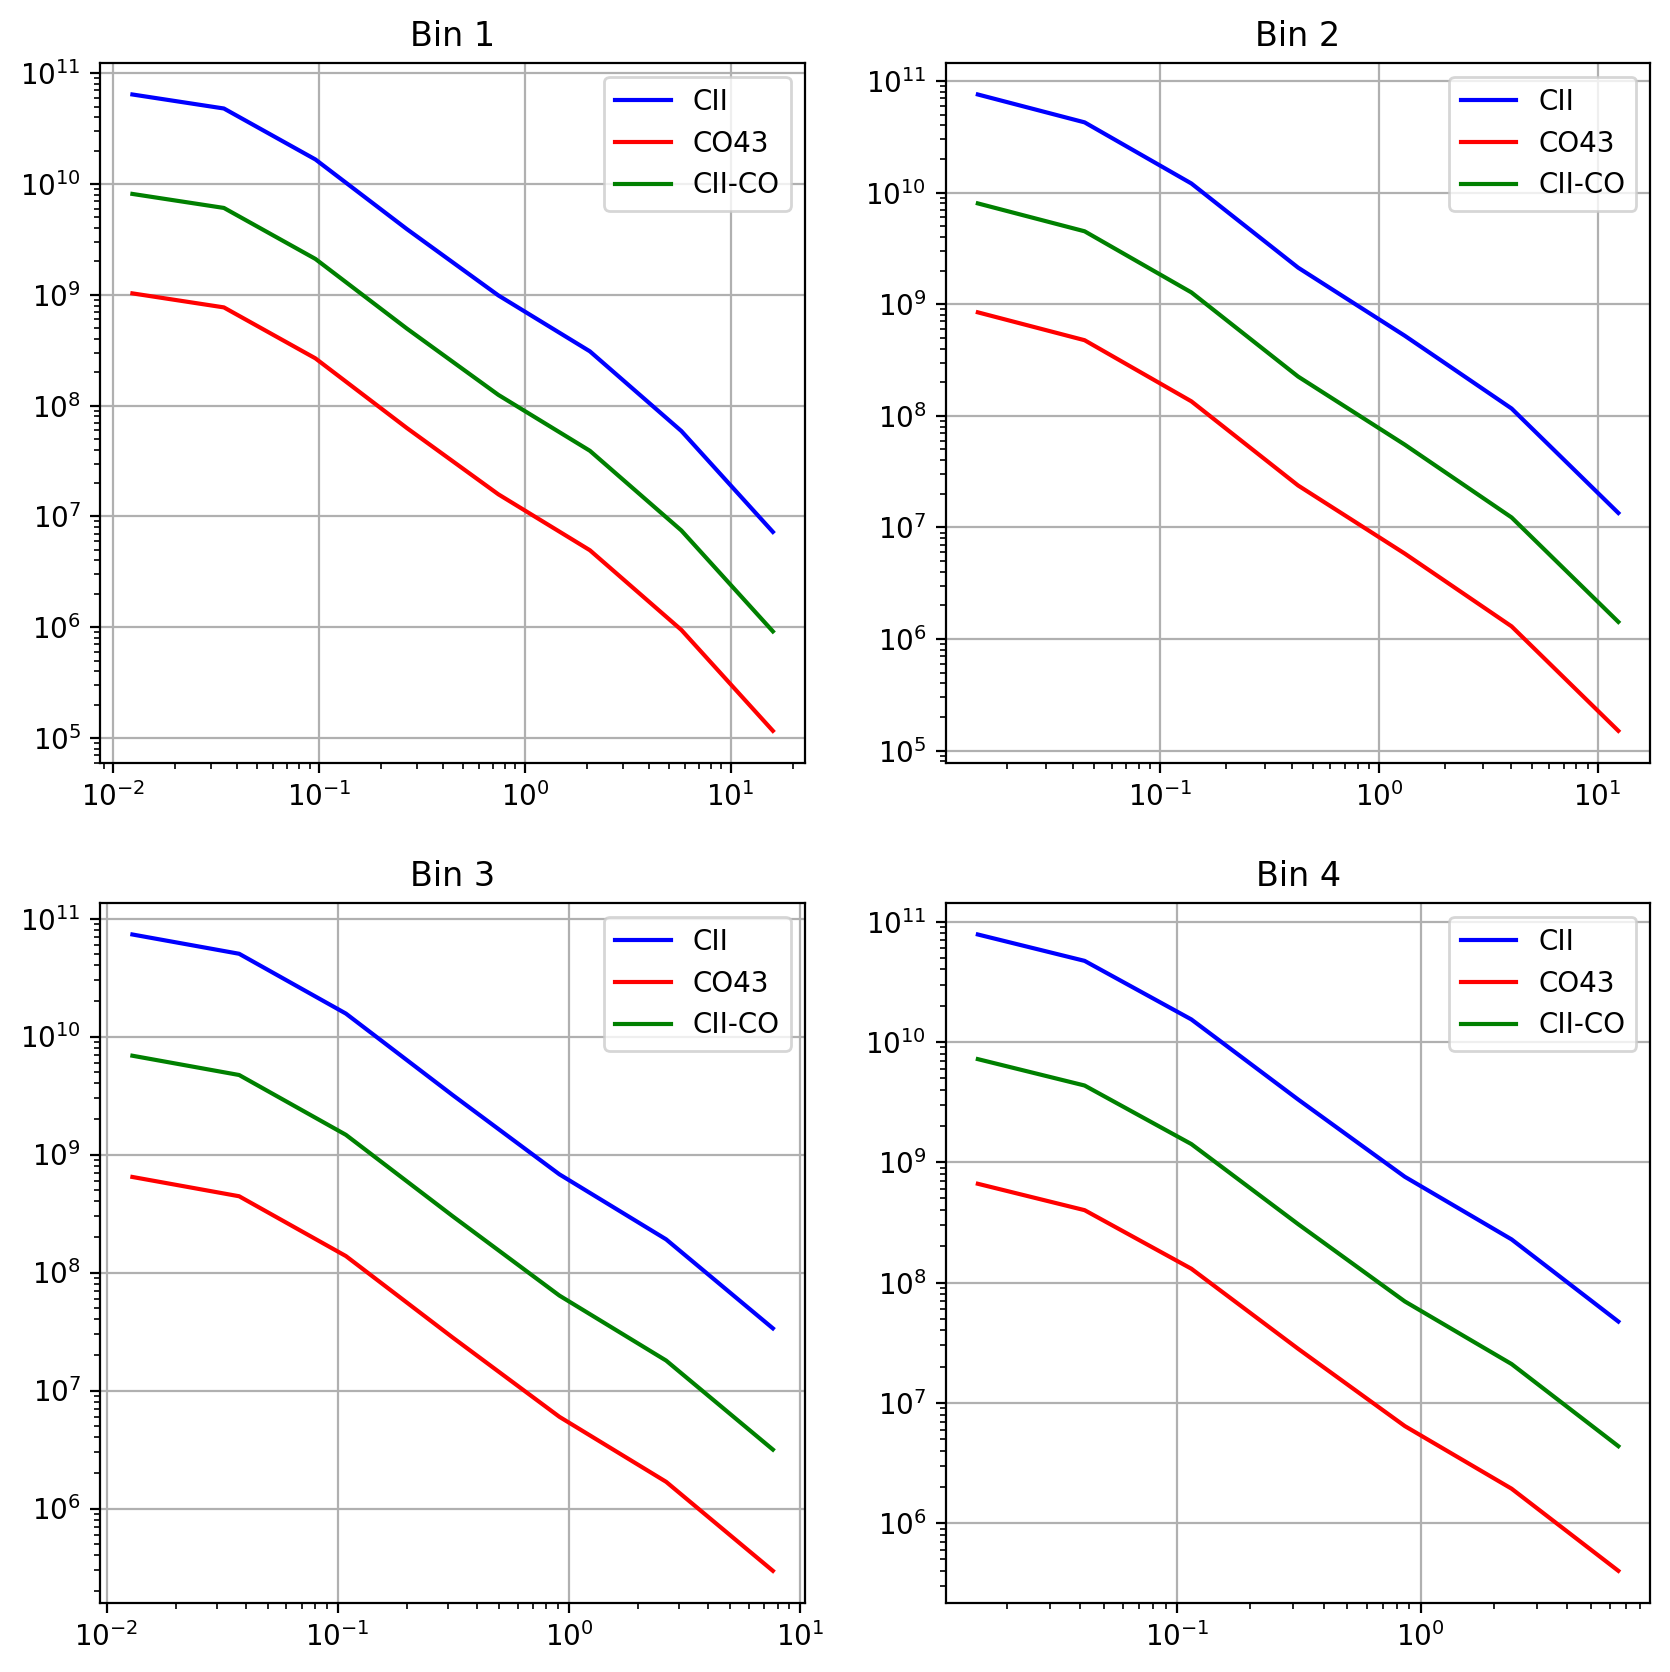

In [32]:
# compute power spectrum of CII and HI
PCIIs = [Icii ** 2 * Pm[1] for Icii, Pm in zip(Iciis, Pms)]
PCO43s = [bIco ** 2 * Pm[1] for bIco, Pm in zip(bI_CO43s, Pms)]

# P_cross, ignoring the shot term for now TODO(shubh)
Pcross = [Icii * bIco * Pm[1] for Icii, bIco, Pm in zip(Iciis, bI_CO43s, Pms)]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
for i in range(len(Pms)):
    # norm = Pms[i][0] ** 3 / (2 * np.pi ** 2)
    norm = 1
    axs[i//2, i%2].plot(Pms[i][0], norm * PCIIs[i], label = 'CII', color = 'blue')
    axs[i//2, i%2].plot(Pms[i][0], norm * PCO43s[i], label = 'CO43', color = 'red')
    axs[i//2, i%2].plot(Pms[i][0], norm * Pcross[i], label = 'CII-CO', color = 'green')
    axs[i//2, i%2].set_xscale('log')
    axs[i//2, i%2].set_yscale('log')
    axs[i//2, i%2].set_title(f"Bin {i+1}")
    axs[i//2, i%2].grid()
    axs[i//2, i%2].legend()

plt.show()
plt.close()

In [39]:
reload(p)
reload(l)
FYST = p.FYST
CO43 = l.CO43

cross_var = [None] * len(bin_zs)
pcii_var = [None] * len(bin_zs)
pco43_var = [None] * len(bin_zs)

for i, z in enumerate(bin_zs):
    nei = TIM.SW.NEI if i < 2 else TIM.LW.NEI
    nei = nei.value * u.Jy / u.sr
    num_pix = TIM.SW.num_dets if i < 2 else TIM.LW.num_dets
    fwhm = TIM.SW.FWHM if i < 2 else TIM.LW.FWHM
    dnu = TIM.SW.dnu if i < 2 else TIM.LW.dnu
    tpix = TIM.time * num_pix * 2 * np.pi * fwhm * fwhm / (8 * np.log(2)) / TIM.Daz / TIM.Del
    Vpix = 1.1e3 / cosmo.h ** 3 * u.Mpc ** 3 * ((1+z) / 8) ** 0.5 * (fwhm / 10 * u.arcmin) ** 2 * \
        (dnu / 400 * u.MHz)
    PNCII = (Vpix * nei * nei / tpix).to("Jy2 Mpc3 / s3").value

    nei = FYST.nei.value * u.Jy / u.sr
    num_pix = FYST.nfeed
    theta = CO43.l * (1 + z) / FYST.Dap
    fwhm = 2 * np.pi * (theta / (8 * np.log(2))) ** 2
    dnu = FYST.dnu
    tpix = FYST.time * num_pix * 2 * np.pi * fwhm * fwhm / (8 * np.log(2)) / TIM.Daz / TIM.Del
    Vpix = 1.1e3 / cosmo.h ** 3 * u.Mpc ** 3 * ((1+z) / 8) ** 0.5 * (fwhm / 10 * u.arcmin) ** 2 * \
        (dnu / 400 * u.MHz) * CO43.l / CII.l
    PNCO43 = (Vpix * nei * nei / tpix).to("Jy2 Mpc3 / s3").value
    
    # ks = Pms[i][0]
    # Vsur = 3.7e7 / cosmo.h ** 3 * u.Mpc ** 3 * ((1+z) / 8) ** 0.5 * (TIM.Daz * TIM.Del / (16 * u.deg ** 2)) * \
    #     (c.c/ut.z2l_CII(bins[i].front) - c.c/ut.z2l_CII(bins[i].back)) / (20 * u.GHz)
    # nmodes = (2 * np.pi) ** -2 * ks ** 2 * Vsur * (ks - np.append([0], ks[:-1]))
    # nmodes = nmodes.to("Mpc3").value
    nmodes = num_modes[i]
    
    # print(nmodes, num_modes[i])
    
    pcii_var[i] = (PCIIs[i] + PNCII) ** 2 / (nmodes)
    pco43_var[i] = (PCO43s[i] + PNCO43) ** 2 / (nmodes)
    cross_var[i] = ((PCIIs[i] + PNCII) * (PCO43s[i] + PNCO43) + Pcross[i] ** 2) / (2 * nmodes)
    
    print(f"bin {i+1}:")
    print("CII:", np.sqrt(np.sum(PCIIs[i] ** 2 / pcii_var[i])))
    print(PCIIs[i] / np.sqrt(pcii_var[i]))
    print("CO:", np.sqrt(np.sum(PCO43s[i] ** 2 / pco43_var[i])))
    print(PCO43s[i] / np.sqrt(pco43_var[i]))
    print("Cross:", np.sqrt(np.sum(Pcross[i] ** 2 / cross_var[i])))
    print(Pcross[i] / np.sqrt(cross_var[i]))

bin 1:
CII: 0.1817542065190764
[0.0975509  0.10456924 0.0609163  0.06636637 0.04773582 0.04128072
 0.02188997 0.00253342]
CO: 121.02770134479677
[ 1.72547193  2.43705377  3.94199462 17.25004567 41.7767258  80.3000734
 77.55866981 10.81391427]
Cross: 4.198473420241244
[0.56458665 0.69922512 0.68786782 1.51058636 1.99638935 2.57461281
 1.84268225 0.23407789]
bin 2:
CII: 0.19891078897697412
[0.10654057 0.10058081 0.10030219 0.06733519 0.04865217 0.03347151
 0.0040221 ]
CO: 106.15399159980899
[ 1.72346684  2.8036054   9.40175929 31.11706504 62.58316672 78.37734702
 11.89593603]
Cross: 4.286321781011659
[0.5882664  0.7380889  1.36649227 2.04548631 2.46739145 2.290566
 0.30934335]
bin 3:
CII: 0.6941375245901624
[0.2991734  0.30698826 0.37222397 0.3064824  0.19687123 0.16138095
 0.02821604]
CO: 105.45911663747742
[ 1.72001877  2.42477305  8.44136821 29.27416694 58.06000206 80.52872919
 18.13046279]
Cross: 8.711464316444477
[0.93727439 1.15084317 2.45655594 4.2196683  4.77865276 5.09781952
 1.

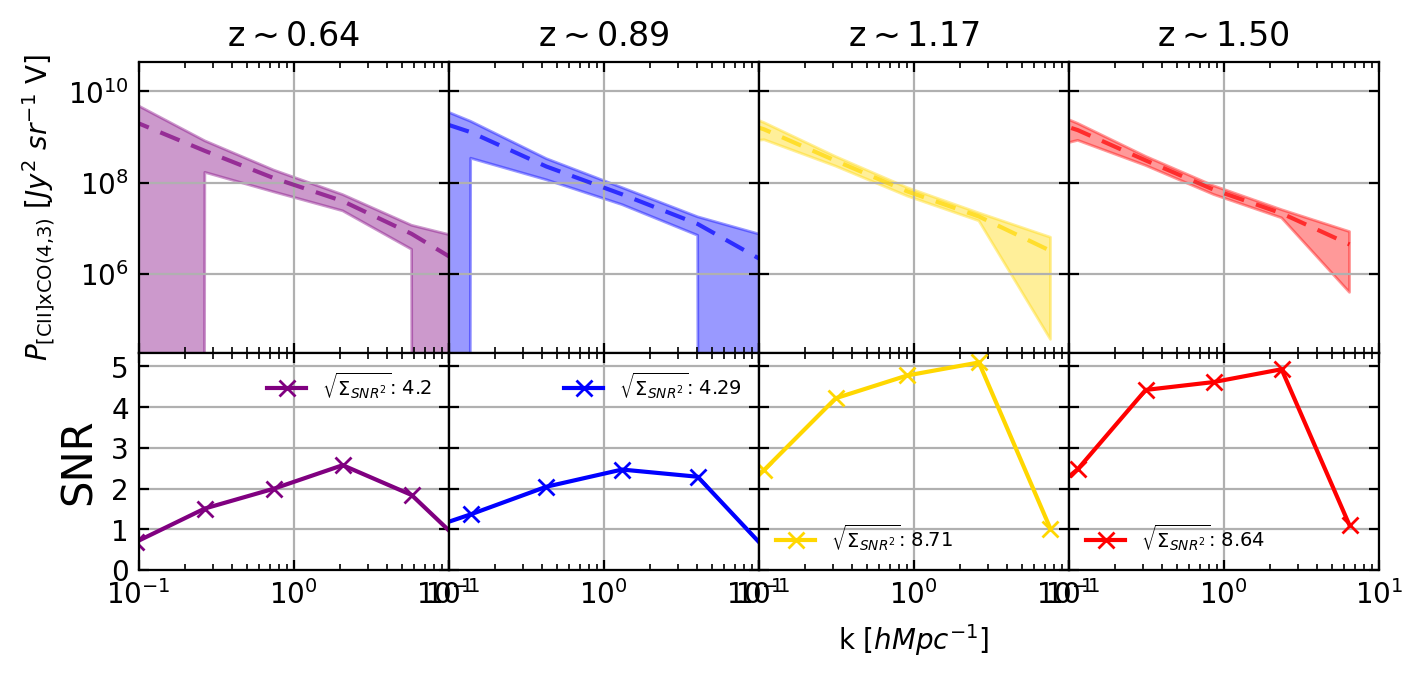

In [41]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(Pcross):
    power[i].loglog(Pms[i][0], Pcross[i], color = colors[i], linestyle = '--', alpha = .7)
    # power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], Pcross[i] + np.sqrt(cross_var[i]),
                   Pcross[i] - np.sqrt(cross_var[i]), color = colors[i], alpha = .4)
    power[i].set_title(r"z$\sim$"+f"{bins[i].center:.2f}")
    
    SNR_Pcross = Pcross[i] / np.sqrt(cross_var[i])
    
    quad_snr = np.sqrt(np.sum(SNR_Pcross ** 2))
    
    SNR[i].plot(Pms[i][0], SNR_Pcross, color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_snr,2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    SNR[i].set_yticks(np.arange(0, 5.1, 1.0))


power[0].set_ylabel(r"$P_\text{[CII]xCO(4,3)}$ [$Jy^2$ $sr^{-1}$ V]", size = 10)

SNR[0].set_ylabel(r"SNR", size = 15)
power[0].set_xlim(1e-1, 1e1)

# power[0].set_ylim(1e3, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

In [549]:
#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.
PxG_Interp = [interp1d(ks, PxG) for (ks, _), PxG in zip(Pms, PxGs)]
SNR_PxG_Interp = [interp1d(ks, SNR) for (ks, _), SNR in zip(Pms, SNR_PxG)]
x_noise_Interp = [interp1d(ks, xn) for (ks, _), xn in zip(Pms, x_noise)]

k4 = Pms[3][0] #isolate the list of k modes in bin 4. We'll use that as our default k list. 
aligned_PxGs = [interp(k4) for interp in PxG_Interp] #Interpolate the forecast signals in all bins at the modes in k4.
aligned_SNRs = np.nan_to_num([interp(k4) for interp in SNR_PxG_Interp]) #same for SNRs - nanToNum sets NaNs = 0.
aligned_x_noises = [interp(k4) for interp in x_noise_Interp]#and x_noises.

In [550]:
#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

#now sum each k as it is measured in each bin so we can report the total SNR per k bin.
SNR_by_k = np.zeros(len(aligned_SNRs[0]))
for SNRks in aligned_SNRs: SNR_by_k += SNRks
totQuadSNR = np.sqrt(np.sum(SNR_by_k**2))

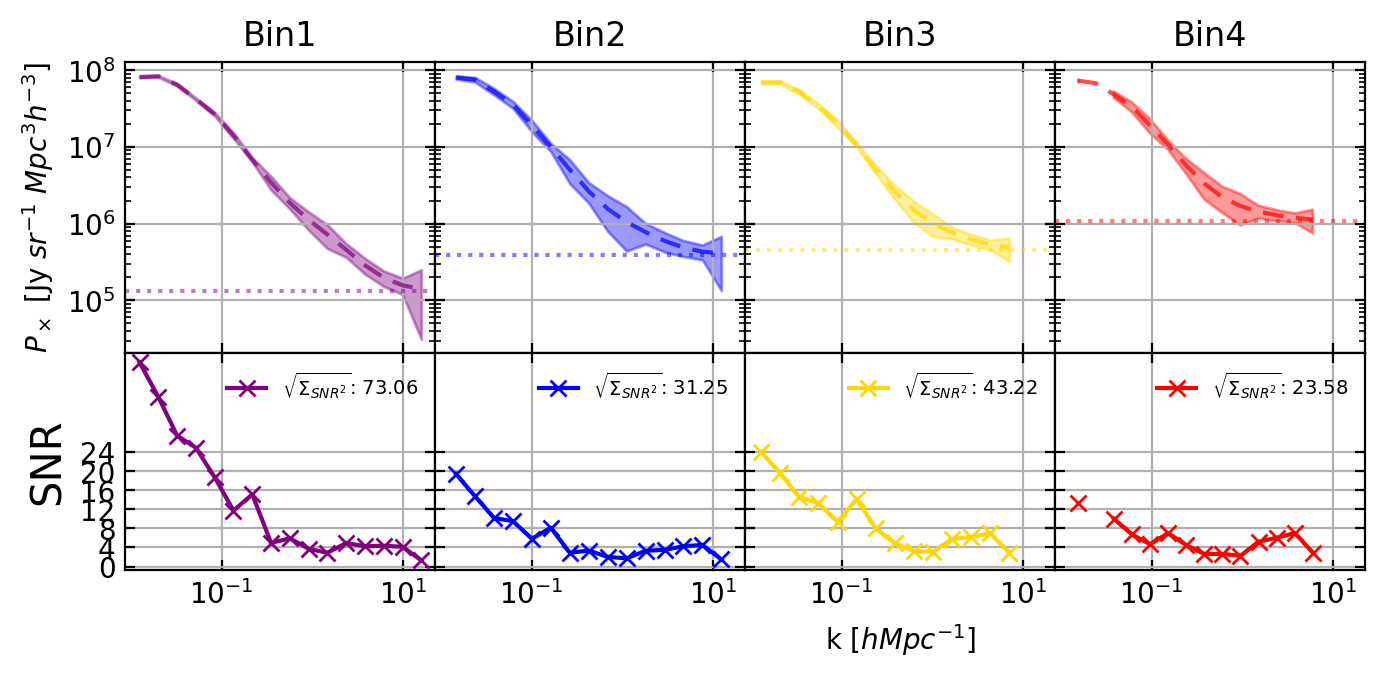

In [551]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + x_noise[i],
                   PxG - x_noise[i], color = colors[i], alpha = .4)
    power[i].set_title('Bin'+str(i+1))

    SNR[i].plot(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    SNR[i].set_yticks(np.arange(0, 26, 4.0))


power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)

SNR[0].set_ylabel(r"SNR", size = 15)
#power[0].set_xlim(1.2e-1, 0.1e2)

#power[0].set_ylim(1e5, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

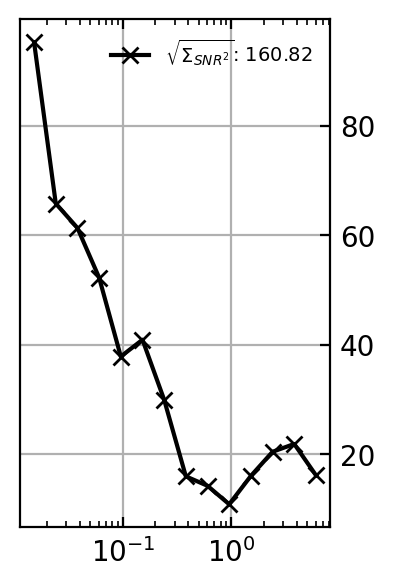

In [552]:
fig, total = plt.subplots(1,1, dpi = 200, figsize = (2,3.3))
total.semilogx(k4, SNR_by_k, color = 'black', marker = 'x', 
        label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(totQuadSNR,2)))
total.grid()
total.legend(fontsize = 7)
total.yaxis.tick_right()

In [553]:
# Changing from proposal SFRD->CII to DeLooze's prescription changes SNR by a small factor 2-4% 
# (depending on z-bin). this percentage/fractional change is exactly same across all k-bins, 

In [554]:
# Changing to Spinoglio's prescription changes SNR by large factors: ~70%
# again, constant across all k-bins, for a given z-bin